In [2]:
from google.colab import files
uploaded = files.upload()
!ls

Saving TFRecords.py to TFRecords.py
sample_data  TFRecords.py


In [1]:
!ls

sample_data


In [3]:
!python TFRecords.py

Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating train.tfrecords


Generating validation.tfrecords
Done!


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time, math

tf.enable_eager_execution()

filename_train = 'train.tfrecords' 
filename_test = 'validation.tfrecords' 
HEIGHT = 32
WIDTH = 32
DEPTH = 3

In [0]:
def normalize(image):
  """Convert `image` from [0, 255] -> [0, 1] floats."""
  image = tf.cast(image, tf.float32) * (1. / 255)
  return image  

def preprocess(image):
    """Preprocess a single image in [height, width, depth] layout."""
    # Pad 4 pixels on each dimension of feature map, done in mini-batch
    image = tf.image.resize_image_with_crop_or_pad(image, 40, 40)
    image = tf.random_crop(image, [HEIGHT, WIDTH, DEPTH])
    image = tf.image.random_flip_left_right(image)
    return image
def replace_slice(input_: tf.Tensor, replacement, begin) -> tf.Tensor:
    inp_shape = tf.shape(input_)
    size = tf.shape(replacement)
    padding = tf.stack([begin, inp_shape - (begin + size)], axis=1)
    replacement_pad = tf.pad(replacement, padding)
    mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
    return tf.where(mask, replacement_pad, input_)
def cutout(x: tf.Tensor, h: int=8, w: int=8, c: int = 3) -> tf.Tensor:
    shape = tf.shape(x)
    x0 = tf.random.uniform([], 0, shape[0] + 1 - h, dtype=tf.int32)
    y0 = tf.random.uniform([], 0, shape[1] + 1 - w, dtype=tf.int32)
    
    x = replace_slice(x, tf.zeros([h, w, c], dtype = tf.float32), [x0, y0, 0])
    return x  

In [0]:
def parser(serialized_example):
    """Parses a single tf.Example into image and label tensors."""
    # Dimensions of the images in the CIFAR-10 dataset.
    # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
    # input format.
    features = tf.parse_single_example(
        serialized_example,
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
        })
    image = tf.decode_raw(features['image'], tf.uint8)
    image.set_shape([DEPTH * HEIGHT * WIDTH])
    image = normalize(image)

    # Reshape from [depth * height * width] to [depth, height, width].
    image = tf.cast(
        tf.transpose(tf.reshape(image, [DEPTH, HEIGHT, WIDTH]), [1, 2, 0]),
        tf.float32)
    label = tf.cast(features['label'], tf.int32)
    label = tf.one_hot(label, 10)

    # Custom preprocessing.
    image = preprocess(image)
    image = cutout(image)

    return image, label  
  
def parser_test(serialized_example):
    """Parses a single tf.Example into image and label tensors."""
    # Dimensions of the images in the CIFAR-10 dataset.
    # See http://www.cs.toronto.edu/~kriz/cifar.html for a description of the
    # input format.
    features = tf.parse_single_example(
        serialized_example,
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
        })
    image = tf.decode_raw(features['image'], tf.uint8)
    image.set_shape([DEPTH * HEIGHT * WIDTH])
    image = normalize(image)

    # Reshape from [depth * height * width] to [depth, height, width].
    image = tf.cast(
        tf.transpose(tf.reshape(image, [DEPTH, HEIGHT, WIDTH]), [1, 2, 0]),
        tf.float32)
    label = tf.cast(features['label'], tf.int32)
    label = tf.one_hot(label, 10)

    return image, label    

In [0]:
# Hyperparameters
num_classes = 10
dropout_rate = 0.15
batch_size = 512
num_epochs = 100

In [0]:
# -----------TRAIN TFRecords
# dataset_train = tf.data.TFRecordDataset(filename_train).repeat(1)
# # dataset_test = dataset_train.apply(tf.contrib.data.shuffle_and_repeat(1,40000))
# # dataset_test = dataset_train.apply(tf.contrib.data.map_and_batch(parser,batch_size))
# dataset_train = dataset_train.map(parser, num_parallel_calls=batch_size)
# dataset_train = dataset_train.shuffle(buffer_size=40000) 

# # Batch it up.
# dataset_train = dataset_train.batch(batch_size)
# # iterator = dataset_train.make_one_shot_iterator()
# # image_batch, label_batch = iterator.get_next()

# -------------TEST TFRecords
dataset_test = tf.data.TFRecordDataset(filename_test).repeat(1)
# dataset_test = dataset_test.apply(tf.contrib.data.shuffle_and_repeat(1,10000))
# dataset_test = dataset_test.apply(tf.contrib.data.map_and_batch(parser,batch_size))

dataset_test = dataset_test.map(parser_test, num_parallel_calls=batch_size)
dataset_test = dataset_test.shuffle(buffer_size=10000) 

# Batch it up.
dataset_test = dataset_test.batch(batch_size)
# iterator = dataset_train.make_one_shot_iterator()
# image_batch, label_batch = iterator.get_next()

In [0]:
import tensorflow as tf

def _stage(tensor, nb_groups, in_channels, out_channels, repeat):
    x = _shufflenet_unit(tensor, nb_groups, in_channels, out_channels, 2)

    for _ in range(repeat):
        x = _shufflenet_unit(x, nb_groups, out_channels, out_channels, 1)

    return x


def _pw_group(tensor, nb_groups, in_channels, out_channels):
    """Pointwise grouped convolution."""
    nb_chan_per_grp = in_channels // nb_groups

    pw_convs = []
    for grp in range(nb_groups):
        x = tf.keras.layers.Lambda(lambda x: x[:, :, :, nb_chan_per_grp * grp: nb_chan_per_grp * (grp + 1)])(tensor)
        grp_out_chan = int(out_channels / nb_groups + 0.5)

        pw_convs.append(
            tf.keras.layers.Conv2D(grp_out_chan,
                   kernel_size=(1, 1),
                   padding='same',
                   use_bias=False,
                   strides=1)(x)
        )

    return tf.keras.layers.Concatenate(axis=-1)(pw_convs)


def _shuffle(x, nb_groups):
    def shuffle_layer(x):
        _, w, h, n = tf.keras.backend.int_shape(x)
        nb_chan_per_grp = n // nb_groups

        x = tf.reshape(x, (-1, w, h, nb_chan_per_grp, nb_groups))
        x = tf.keras.backend.permute_dimensions(x, (0, 1, 2, 4, 3)) # Transpose only grps and chs
        x = tf.reshape(x, (-1, w, h, n))

        return x

    return tf.keras.layers.Lambda(shuffle_layer)(x)


def _shufflenet_unit(tensor, nb_groups, in_channels, out_channels, strides, shuffle=True, bottleneck=4):
    bottleneck_channels = out_channels // bottleneck

    x = _pw_group(tensor, nb_groups, in_channels, bottleneck_channels)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    if shuffle:
        x = _shuffle(x, nb_groups)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3),
                        padding='same',
                        use_bias=False,
                        strides=strides)(x)
    x = tf.keras.layers.BatchNormalization()(x)


    x = _pw_group(x, nb_groups, bottleneck_channels,
                  out_channels if strides < 2 else out_channels - in_channels)
    x = tf.keras.layers.BatchNormalization()(x)

    if strides < 2:
        x = tf.keras.layers.Add()([tensor, x])
    else:
        avg = tf.keras.layers.AveragePooling2D(pool_size=(3, 3),
                               strides=2,
                               padding='same')(tensor)

        x = tf.keras.layers.Concatenate(axis=-1)([avg, x])

    x = tf.keras.layers.Activation('relu')(x)

    return x


def _info(nb_groups):
    return {
        1: [24, 144, 288, 576],
        2: [24, 200, 400, 800],
        3: [24, 240, 480, 960],
        4: [24, 272, 544, 1088],
        8: [24, 384, 768, 1536]
    }[nb_groups], [None, 3, 7, 3]


def ShuffleNet(input_shape, nb_classes, include_top=True, weights=None, nb_groups=3):
    x_in = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(24,
               kernel_size=(3, 3),
               strides=2,
               use_bias=False,
               padding='same')(x_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3),
                     strides=2,
                     padding='same')(x)

    channels_list, repeat_list = _info(nb_groups)
    for i, (out_channels, repeat) in enumerate(zip(channels_list[1:], repeat_list[1:]), start=1):
        x = _stage(x, nb_groups, channels_list[i-1], out_channels, repeat)

    if include_top:
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(nb_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=x_in, outputs=x)

    if weights is not None:
        model.load_weights(weights, by_name=True)

    return model

In [26]:
model = ShuffleNet((32,32,3),10)
model.summary()
# print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 16, 16, 24)   648         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 16, 16, 24)   96          conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 16, 16, 24)   0           batch_normalization_98[0][0]     
____________________________________________________________________________________________

In [18]:
print(len(list(dataset_train)))
print(len(list(dataset_test)))

98
20


#### ShuffleNet training and evaluation.

Trained for 100 epochs and achieved 67.39% accuracy on validaton dataset.

Each epoch takes 18 seconds with a batch size of 512.

In [19]:
import time
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)

# tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
                optimizer=sgd,
                metrics=['accuracy'])
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
start_time = time.time()
for zz in range(1,num_epochs+1):
  dataset_train = tf.data.TFRecordDataset(filename_train).repeat(1)
  # dataset_test = dataset_train.apply(tf.contrib.data.shuffle_and_repeat(1,40000))
  # dataset_test = dataset_train.apply(tf.contrib.data.map_and_batch(parser,batch_size))
  dataset_train = dataset_train.map(parser, num_parallel_calls=batch_size)
  dataset_train = dataset_train.shuffle(buffer_size=50000) 
  dataset_train = dataset_train.batch(batch_size)
  # determine Loss function and Optimizer
  print("TrainEpochs number{}/{}".format(zz,num_epochs))
  
  model.fit_generator(dataset_train,steps_per_epoch=int(50000/batch_size),epochs=1,verbose=1)#,validation_data=dataset_test)

  print("Test Epochs number{}/{}".format(zz,num_epochs))
  model.evaluate_generator(dataset_test,steps=int(10000/batch_size),verbose=1)
  print("  ")
  print("------------------------",time.time()-start_time)

TrainEpochs number1/100
97/97 [==============================] - 76s 779ms/step - loss: 4.3648 - acc: 0.2110
Test Epochs number1/100
19/19 [==============================] - 3s 173ms/step - loss: 2.6685 - acc: 0.0990
  
------------------------ 79.03634095191956
TrainEpochs number2/100
97/97 [==============================] - 18s 189ms/step - loss: 3.4035 - acc: 0.3051
Test Epochs number2/100
19/19 [==============================] - 1s 54ms/step - loss: 2.9647 - acc: 0.1630
  
------------------------ 98.58205103874207
TrainEpochs number3/100
97/97 [==============================] - 18s 190ms/step - loss: 3.1795 - acc: 0.3546
Test Epochs number3/100
19/19 [==============================] - 1s 58ms/step - loss: 3.2874 - acc: 0.2727
  
------------------------ 118.33120489120483
TrainEpochs number4/100
97/97 [==============================] - 19s 191ms/step - loss: 3.0520 - acc: 0.3874
Test Epochs number4/100
19/19 [==============================] - 1s 56ms/step - loss: 3.2720 - acc: 0.3

#### VISUALIZING CUTOUT

In [0]:
batch_size = 5

dataset_train = tf.data.TFRecordDataset(filename_train).repeat(1)
# dataset_test = dataset_train.apply(tf.contrib.data.shuffle_and_repeat(1,40000))
# dataset_test = dataset_train.apply(tf.contrib.data.map_and_batch(parser,batch_size))
dataset_train = dataset_train.map(parser, num_parallel_calls=batch_size)
dataset_train = dataset_train.shuffle(buffer_size=40000) 
dataset_train = dataset_train.batch(batch_size)

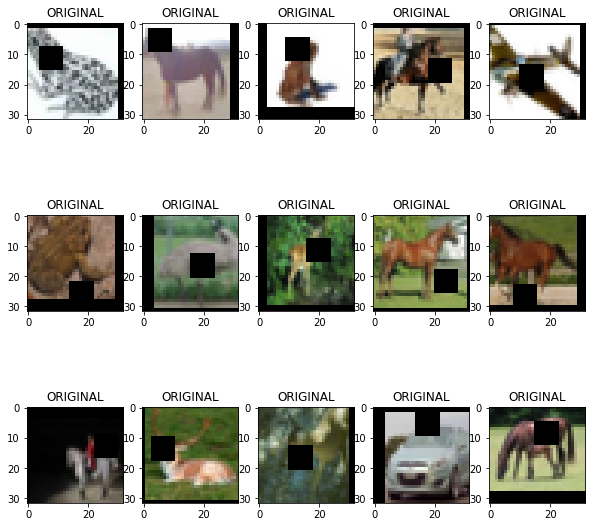

In [21]:
% matplotlib inline
z=0
fig, ax = plt.subplots(3,5, figsize=(10,10))
for j,i in enumerate(dataset_train):
#     print("test",i[0].shape,i[1].shape,j)
    for l,k in enumerate(i[0]):
#         print(k.shape)
#         print(z,l)
        ax[z,l].imshow(k)
        ax[z,l].set_title("ORIGINAL")
    z += 1
    if z == 3:  
      break

#### MISS-CLASSIFIED IMAGES

In [22]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


In [23]:
import numpy as np
import matplotlib.pyplot as plt

j,t = 0, 0
X_test_wrong = []
X_test_wrong_raw = []
for i in range(len(test_features)):
  img_data = test_features[i].astype('float32')
  img_data /= 255
  img_data = np.expand_dims(img_data, axis=0)
#   img_data = test_features[i].reshape(1, 32, 32,3)
  t += 1
#   print(model.predict(img_data)[0])
#   print(np.argmax(model.predict(img_data)[0]))
#   print(test_labels[i][0])
  if np.argmax(model.predict(img_data)[0]) != test_labels[i][0]:
    X_test_wrong.append((img_data, np.argmax(model.predict(img_data)[0]), test_labels[i][0]))
    X_test_wrong_raw.append((test_features[i], np.argmax(model.predict(img_data)[0]), test_labels[i][0]))
    j += 1
  if j >= 50:
    break
print('totla false preds {} for samples {}'.format(j,t))

totla false preds 50 for samples 136


In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

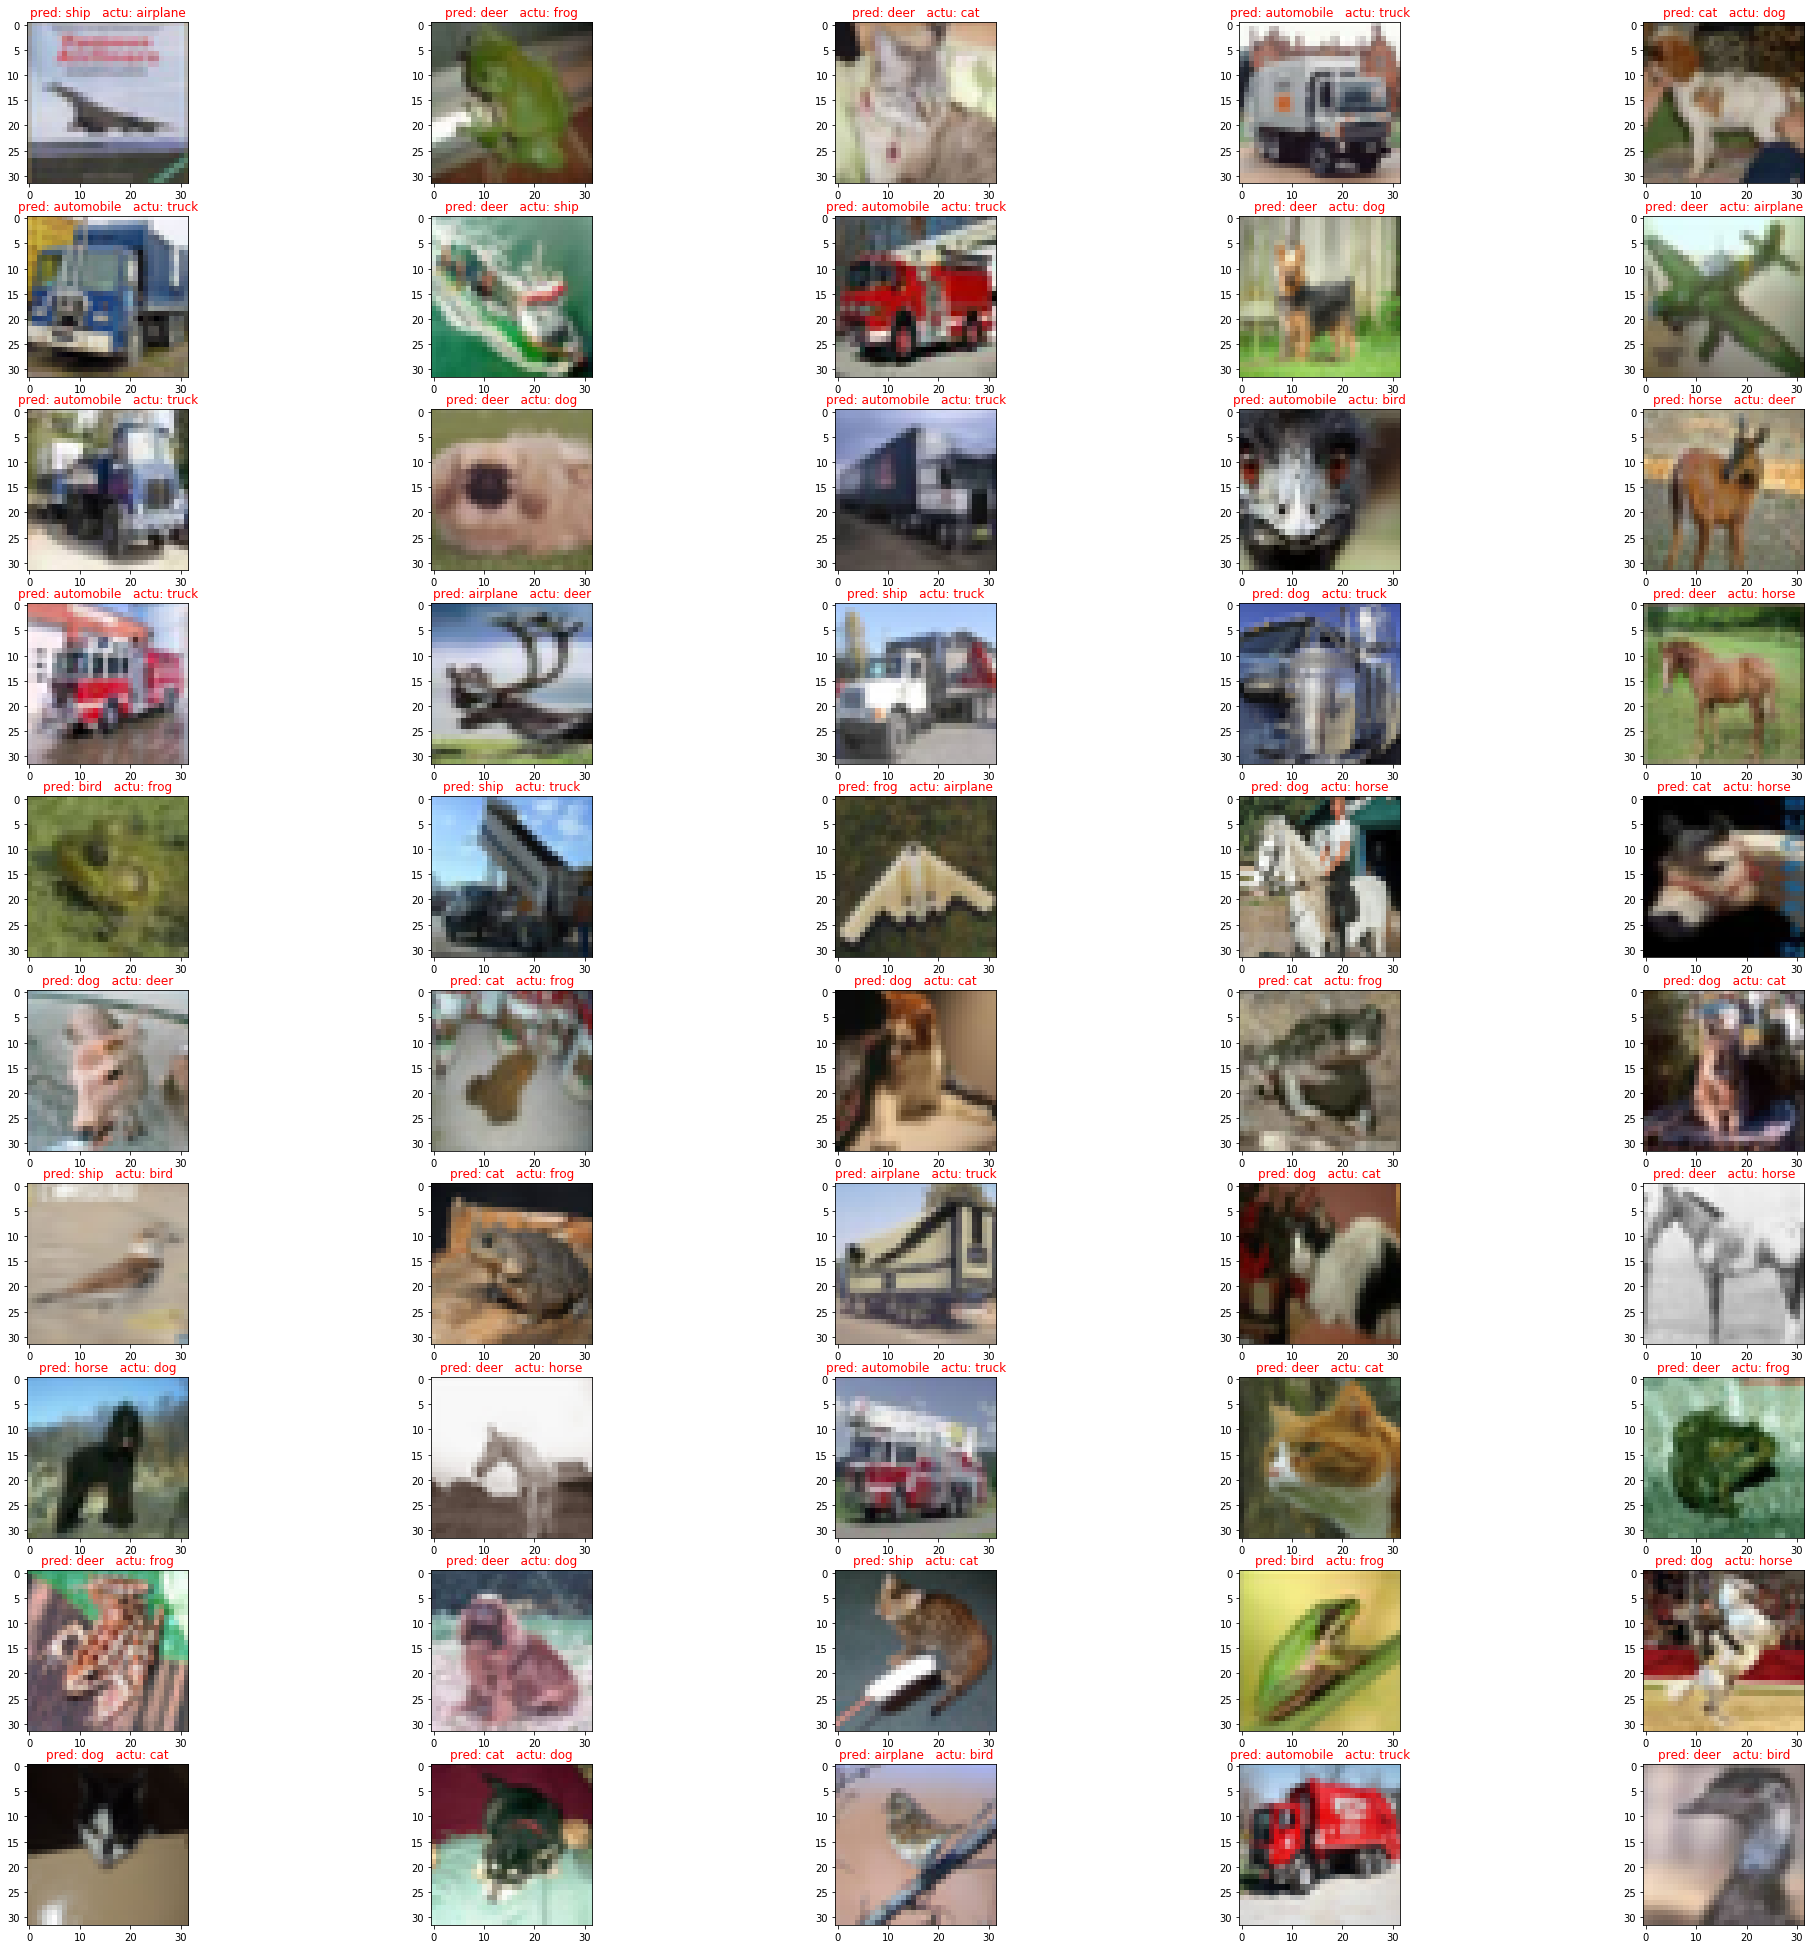

In [25]:
plt.figure(figsize=(35,35))
batch_size = 25
i = 0
for img in X_test_wrong:
  ax = plt.subplot(10,5,i+1)
  ax.set_title("pred: {}   actu: {}".format(class_names[img[1]], class_names[img[2]]), color='r')
  plt.imshow(np.reshape(np.uint8(255 * img[0]), (32,32,-1)), cmap=plt.cm.gray)
  i += 1